In [1]:
# Install libraries (only if needed, uncomment if running first time)
# !pip install transformers
# !pip install umap-learn
# !pip install tqdm

# Import all necessary libraries
import pandas as pd
import numpy as np
import re
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import umap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load NOTEEVENTS file
path = '/content/drive/MyDrive/Capstone Data/NOTEEVENTS.csv'
chunksize = 10000
filtered_notes = []

for chunk in pd.read_csv(path, chunksize=chunksize):
    chunk['CATEGORY'] = chunk['CATEGORY'].str.strip()  # Clean trailing spaces
    chunk = chunk[chunk['CATEGORY'].isin(['Discharge summary', 'Physician', 'Nursing'])]
    chunk = chunk[chunk['TEXT'].notnull() & (chunk['TEXT'].str.len() > 100)]
    filtered_notes.append(chunk)

note_df = pd.concat(filtered_notes, ignore_index=True)

print(f"Total filtered notes: {len(note_df)}")
note_df[['HADM_ID', 'CATEGORY', 'TEXT']].head()

Total filtered notes: 421946


,HADM_ID,CATEGORY,TEXT
0,167853.0,Discharge summary,Admission Date: [**2151-7-16**] Dischar...
1,107527.0,Discharge summary,Admission Date: [**2118-6-2**] Discharg...
2,167118.0,Discharge summary,Admission Date: [**2119-5-4**] D...
3,196489.0,Discharge summary,Admission Date: [**2124-7-21**] ...
4,135453.0,Discharge summary,Admission Date: [**2162-3-3**] D...


In [4]:
print("Unique categories:", note_df['CATEGORY'].nunique())
print("Category names:", note_df['CATEGORY'].unique())

Unique categories: 3
Category names: ['Discharge summary' 'Nursing' 'Physician']


In [ ]:
# Preprocessing function
def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'\[\*\*.*?\*\*\]', '', text)  # Removing de-identified markers
    text = re.sub(r'\n', ' ', text)  # Remove newlines
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with single
    return text.strip()

# Applying preprocessing
note_df['clean_text'] = note_df['TEXT'].apply(preprocess)

print(note_df[['CATEGORY', 'clean_text']].head())


            CATEGORY                                         clean_text
0  Discharge summary  admission date: discharge date: service: adden...
1  Discharge summary  admission date: discharge date: date of birth:...
2  Discharge summary  admission date: discharge date: service: cardi...
3  Discharge summary  admission date: discharge date: service: medic...
4  Discharge summary  admission date: discharge date: date of birth:...


In [ ]:
# If you want only 1 best note per HADM_ID
note_df['length'] = note_df['clean_text'].str.len()
note_df = note_df.sort_values(['HADM_ID', 'length'], ascending=[True, False])
note_df = note_df.groupby('HADM_ID').head(1).reset_index(drop=True)

print(f"Notes after selecting 1 per admission: {len(note_df)}")


Notes after selecting 1 per admission: 52997


In [ ]:
# Set up Bio_ClinicalBERT
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
model = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT").to(device)
model.eval()

In [ ]:
# Batch embedding function
def get_bert_embedding(text_list, batch_size=32, test_mode=False):
    if test_mode:
        text_list = text_list[:100]

    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size), desc="Embedding notes"):
        batch = text_list[i:i+batch_size]

        try:
            encoded = tokenizer(batch, padding=True, truncation=True, max_length=512, return_tensors='pt')
            input_ids = encoded['input_ids'].to(device)
            attention_mask = encoded['attention_mask'].to(device)

            with torch.no_grad():
                output = model(input_ids, attention_mask=attention_mask)
                batch_embeddings = output.last_hidden_state.mean(dim=1)
                embeddings.extend(batch_embeddings.cpu().numpy())

        except Exception as e:
            print(f"Error on batch {i}: {e}")
            continue

    return np.array(embeddings)


In [ ]:
note_texts = note_df['clean_text'].tolist()
note_labels = note_df['CATEGORY'].tolist()

# Generate embeddings
embeddings = get_bert_embedding(note_texts, batch_size=32)

# Save embeddings + labels
embedding_df = pd.DataFrame(embeddings)
embedding_df['CATEGORY'] = note_labels
embedding_df.to_csv("/content/drive/MyDrive/final_note_embeddings.csv", index=False)

print(f"Saved embeddings with shape: {embedding_df.shape}")


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


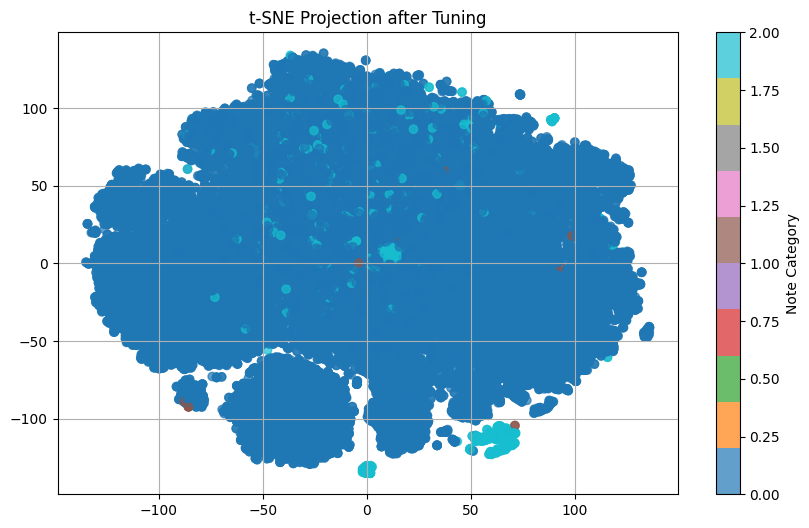

Silhouette Score: 0.06037929753620918
Davies-Bouldin Index: 3.995566780321885


In [ ]:
# Load the saved embeddings
df = pd.read_csv("/content/drive/MyDrive/final_note_embeddings.csv")
X = df.drop(columns=['CATEGORY']).values
y = LabelEncoder().fit_transform(df['CATEGORY'])

# Normalize
X_scaled = StandardScaler().fit_transform(X)

# t-SNE
tsne = TSNE(n_components=2, perplexity=10, n_iter=1500, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

# Plot t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Note Category')
plt.title("t-SNE Projection after Tuning")
plt.grid(True)
plt.show()

# Evaluation scores
print("Silhouette Score:", silhouette_score(X_scaled, y))
print("Davies-Bouldin Index:", davies_bouldin_score(X_scaled, y))


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


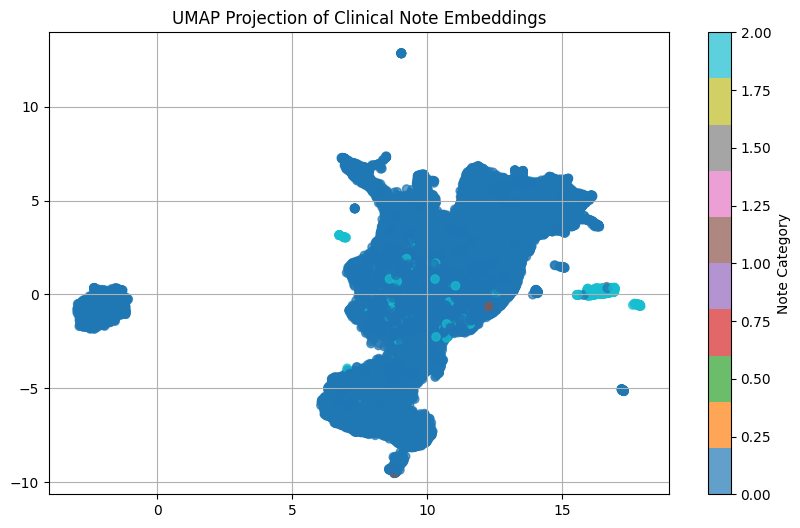

In [ ]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=y, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Note Category')
plt.title("UMAP Projection of Clinical Note Embeddings")
plt.grid(True)
plt.show()
